In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib as plb
import seaborn as sns
from scipy import stats
import statistics
import dabest as db

In [2]:
#Reading in the metadata
base_folder = plb.Path('C:/Users/Emily/Desktop/current_analysis/Tax-4 mutant pooled data/')
md_path = base_folder.joinpath('Collective_Batch_results.csv')
md_df = pd.read_csv(md_path)

#Dropping unecessary columns and altering data types
md_df = md_df.drop(columns=['ID', 'Passes QC'])
md_df['Plate ID'] = md_df['Plate ID'].fillna(0).astype(int)
print(len(md_df))

md_df = md_df.replace("SA2", "SA")

#filtering for wells that have >= 150 worms
over_150 = md_df[md_df['Total Worms'] >= 150]
print(len(over_150))

997
114


In [3]:
blind_key =  pd.read_csv('C:/Users/Emily/Desktop/current_analysis/Tax-4 mutant pooled data/SALV_A_BLINDKEY.csv')
blind_key.head()

,Strain_UB,Blind
0,PY7502,AL
1,OH13089,CO
2,PY7505,DE
3,JN2113,GA
4,JN1715,ID


In [4]:
def add_strain(row, blind_key):
    strain_ID = blind_key.loc[
        blind_key['Blind']==row['Strain']]['Strain_UB']
    #print(strain_ID.values[0])
    return strain_ID.values[0]

over_150['Strain_UB'] = over_150.apply(
    lambda row: add_strain(row, blind_key), axis=1)

over_150.head()

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Chemotaxis,Compound,Strain,File Name,WellNo,Total Worms,Plate ID,Strain_UB
0,0.214286,DMSO,AL,20211122_SA_tax-4mut_001,1A,232.0,1,PY7502
1,0.152866,DMSO,CO,20211122_SA_tax-4mut_001,1B,362.0,1,OH13089
3,-0.007092,DMSO,GA,20211122_SA_tax-4mut_001,1D,323.0,1,JN2113
4,-0.011673,DMSO,AL,20211122_SA_tax-4mut_001,2A,302.0,2,PY7502
5,0.194539,DMSO,CO,20211122_SA_tax-4mut_001,2B,333.0,2,OH13089


In [5]:
#over_150.to_csv('C:/Users/Emily/Desktop/current_analysis/Tax-4 mutant pooled data/over150.csv')

In [6]:
def get_worm_locs(row, wrms, result_dict): 
    
    filename = row['File Name']
    well = row['WellNo']

    filepath = base_folder.joinpath('loc_' + filename + '_' + well + '.csv')
    #temp = pd.read_csv(loc_fname)
    
    
    if filepath.is_file():
        data = pd.read_csv(filepath)
        strain = row['Strain_UB']
        xs = data['X']

        if strain in result_dict:
            result_dict[strain] = result_dict[strain].append(xs)
            result_dict[strain].reset_index(inplace=True, drop=True)
            #result_dict[strain] = result_dict[strain]+xs
        else:
            result_dict[strain]=xs
        return result_dict
    
    else: 
        pass
    

In [7]:
def subst(df, strain, compound, path):
    temp = df.loc[(df['Strain_UB']==strain) & 
            (df['Compound']==compound)]
    # Need to create an empty dictionary to hold the values
    return temp

In [8]:
# 1 inch = 25.4mm
mm = 25.4
# 1200 pixels per 25.4mm
px_mm = 1200/mm

In [9]:
strains = list(over_150['Strain_UB'].unique())
compounds = list(over_150['Compound'].unique())
n2 = strains.pop(4)
strains.insert(0, n2)
print(strains)
#db_obj = db.load(pooled_df, idx=strains)

['N2', 'PY7502', 'OH13089', 'JN2113', 'JN1715', 'PS6025', 'PR678', 'GN580', 'CX7102']


In [10]:
all_strains = pd.DataFrame()
compound = 'DMSO'

i = 0
for s in strains:
    test = subst(over_150, s, compound, base_folder)
    all_strains = all_strains.append(test)
    
# Need to create an empty dictionary to hold the values
results_dict = {}
for index, row in all_strains.iterrows():
    pooled = get_worm_locs(row, base_folder, results_dict)

pooled_df = pd.DataFrame.from_dict(pooled)
mm_df = pooled_df.apply(lambda x: -(x/px_mm)+32.5)
#pooled_df.to_csv(base_folder.joinpath(compound+'_dpi.csv'))
#mm_df.to_csv(base_folder.joinpath(compound+'_mm.csv'))
mm_df.head()

,N2,PY7502,OH13089,JN2113,JN1715,PS6025,PR678,GN580,CX7102
0,-23.855239,-22.371111,-3.896393,-9.792398,13.699481,8.646271,25.701827,18.792581,-7.626448
1,-4.921007,-12.896322,13.299958,-16.688708,-15.163136,-17.059169,3.963641,-1.157524,-10.163961
2,8.310884,13.615437,-14.610322,-15.211912,2.678450,1.964625,-7.914351,-8.291044,-3.134661
3,-14.325390,-11.121019,23.135594,14.529372,21.096596,16.573365,-5.831530,-8.158718,-18.162305
4,10.956783,-18.449129,-16.673222,16.413561,-8.954251,-17.058157,-7.057079,-1.588552,4.940465


In [11]:
new_obj = db.load(mm_df, idx=strains)


C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  app.launch_new_instance()
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


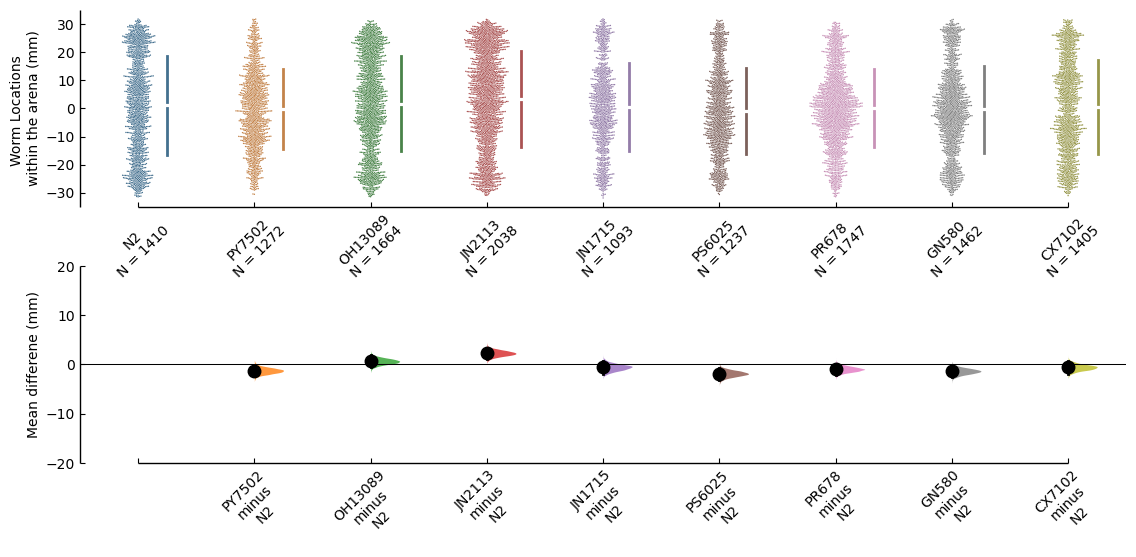

In [13]:
# Generating the plots
mm_refs_plot = new_obj.mean_diff.plot(raw_marker_size=1, swarm_label = 'Worm Locations \nwithin the arena (mm)', 
                                        contrast_label="Mean differene (mm)", contrast_ylim = (-20,20), swarm_ylim=(-35,35))

#Accessing plot axes to control plot asthetics
rawswarm_axes = mm_refs_plot.axes[0]
contrast_axes = mm_refs_plot.axes[1]

rawswarm_axes.yaxis.set_tick_params(tickdir='in')
rawswarm_axes.xaxis.set_tick_params(tickdir='in', rotation=45)

contrast_axes.yaxis.set_tick_params(tickdir='in')
contrast_axes.xaxis.set_tick_params(tickdir='in', rotation=45)
#plt.rcParams['svg.fonttype'] = 'none'

plt.savefig('C:/Users/Emily/Desktop/current_analysis/Tax-4 mutant pooled data/salva_figs/DMSO.png', dpi=300)

In [20]:
def get_worm_locs_pairwise(row, wrms, result_dict): 
    
    filename = row['File Name']
    well = row['WellNo']

    filepath = base_folder.joinpath('loc_' + filename + '_' + well + '.csv')
    #temp = pd.read_csv(loc_fname)
    
    
    if filepath.is_file():
        data = pd.read_csv(filepath)
        strain = row['Strain_UB']
        xs = data['X']
        compound = row['Compound']

        if compound in result_dict:
            result_dict[compound] = result_dict[compound].append(xs)
            result_dict[compound].reset_index(inplace=True, drop=True)
            #result_dict[strain] = result_dict[strain]+xs
        else:
            result_dict[compound]=xs
        return result_dict
    
    else: 
        pass
    
def subst(df, strain, compound, path):
    temp = df.loc[(df['Strain_UB']==strain) & 
            (df['Compound']==compound)]
    print(temp)
    # Need to create an empty dictionary to hold the values
    return temp

In [25]:

all_comps = pd.DataFrame()
strain = 'N2'

for c in compounds:
    test = subst(over_150, strain, c, base_folder)
    all_comps = all_comps.append(test)
    
# Need to create an empty dictionary to hold the values
results_dict = {}
for index, row in all_comps.iterrows():
    pooled = get_worm_locs_pairwise(row, base_folder, results_dict)

pooled_df = pd.DataFrame.from_dict(pooled)
strain_df = pooled_df.apply(lambda x: -(x/px_mm)+32.5)
#pooled_df.to_csv(base_folder.joinpath(compound+'_dpi.csv'))
#mm_df.to_csv(base_folder.joinpath(compound+'_mm.csv'))
strain_df.head()

strain_obj = db.load(strain_df, idx=compounds)


     Chemotaxis Compound Strain                 File Name WellNo  Total Worms  \
33     0.175097     DMSO     KY   20211208_SA_tax-4mut001     1B        313.0   
37    -0.059140     DMSO     KY   20211208_SA_tax-4mut001     2B        409.0   
51     0.209302     DMSO     KY  20211222_SA_tax-4mut_001     1D        193.0   
55     0.010753     DMSO     KY  20211222_SA_tax-4mut_001     2D        211.0   
117    0.021277     DMSO     KY  20220209_SA_tax-4mut_002     2B        284.0   

     Plate ID Strain_UB  
33          1        N2  
37          2        N2  
51          1        N2  
55          2        N2  
117         2        N2  
     Chemotaxis Compound Strain                 File Name WellNo  Total Worms  \
23    -0.150685       SA     KY  20211206_SA_tax-4mut_001     2D        159.0   
41    -0.055118       SA     KY   20211208_SA_tax-4mut001     3B        298.0   
45     0.210000       SA     KY   20211208_SA_tax-4mut001     4B        226.0   
59    -0.243902       SA     KY  

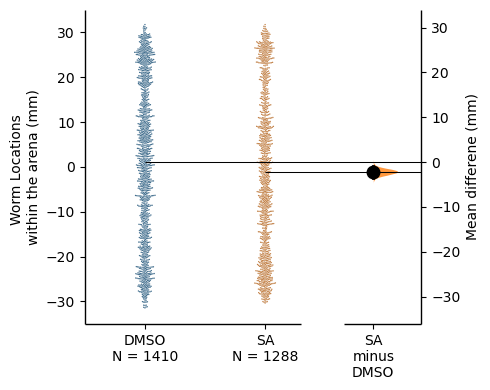

In [28]:
# Generating the plots
strain_refs_plot = strain_obj.mean_diff.plot(raw_marker_size=1, swarm_label = 'Worm Locations \nwithin the arena (mm)', 
                                        contrast_label="Mean differene (mm)", swarm_ylim=(-35,35))

#Accessing plot axes to control plot asthetics
rawswarm_axes = mm_refs_plot.axes[0]
contrast_axes = mm_refs_plot.axes[1]

rawswarm_axes.yaxis.set_tick_params(tickdir='in')
rawswarm_axes.xaxis.set_tick_params(tickdir='in', rotation=45)

contrast_axes.yaxis.set_tick_params(tickdir='in')
contrast_axes.xaxis.set_tick_params(tickdir='in', rotation=45)

plt.savefig('C:/Users/Emily/Desktop/current_analysis/Tax-4 mutant pooled data/salva_figs/N2.png', dpi=300)